In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from qiskit import execute, Aer, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.providers.aer import StatevectorSimulator, QasmSimulator, UnitarySimulator
import numpy as np

In [122]:
# from https://stackoverflow.com/questions/9600801/evenly-distributing-n-points-on-a-sphere

import math
def fibonacci_sphere(samples=1000):

    points = []
    phi = math.pi * (3. - math.sqrt(5.))  # golden angle in radians

    for i in range(samples):
        y = 1 - (i / float(samples - 1)) * 2  # y goes from 1 to -1
        radius = math.sqrt(1 - y * y)  # radius at y

        theta = phi * i  # golden angle increment

        x = math.cos(theta) * radius
        z = math.sin(theta) * radius

        points.append((x, y, z))

    return points

(1, 32) (32, 1)


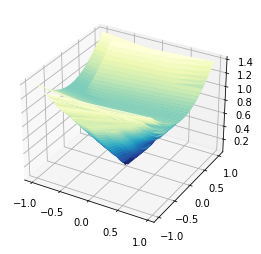

(32, 3)
[-0.99445642 -0.09677419  0.0411239 ]


In [150]:
plt.rcParams["figure.figsize"] = [7.00, 3.5]
plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
points = np.array(fibonacci_sphere(samples=32))
# u, v = np.mgrid[1:-1:16j, 0:1:16j]
# phi = math.pi * (3. - math.sqrt(5.))  # golden angle in radians
# y = u
# indices = np.array(range(16))
# radius = np.sqrt(1 - y * y)
# x = np.cos(phi * indices) * radius
# z = np.sin(phi * indices) * radius
# # print(points.shape)
# # print(points[:,0])
# # ax.plot_trisurf(points[:,0], points[:,1], points[:,2], cmap=plt.cm.YlGnBu_r)
# ax.plot_surface(x, y, z, cmap=plt.cm.YlGnBu_r)
# plt.show()

x, y, z = points[:,0], points[:,1], points[:,2]
x = np.array([x])
y = np.array([y]).T
print(x.shape, y.shape)
z = np.sqrt(x**2 + y**2)
# ax.scatter(x, y, z)
ax.plot_surface(x, y, z, cmap=plt.cm.YlGnBu_r)
plt.show()

print(points.shape)
points = np.array(fibonacci_sphere(samples=32))
diff = points - (-1, 0, 0)
# print(diff)
print(points[np.argmin(np.linalg.norm(diff, axis=1))])

[[[0.         0.         0.         0.        ]
  [0.         0.         0.         0.        ]
  [0.         0.         0.         0.        ]
  [0.         0.         0.         0.        ]]

 [[0.33333333 0.33333333 0.33333333 0.33333333]
  [0.33333333 0.33333333 0.33333333 0.33333333]
  [0.33333333 0.33333333 0.33333333 0.33333333]
  [0.33333333 0.33333333 0.33333333 0.33333333]]

 [[0.66666667 0.66666667 0.66666667 0.66666667]
  [0.66666667 0.66666667 0.66666667 0.66666667]
  [0.66666667 0.66666667 0.66666667 0.66666667]
  [0.66666667 0.66666667 0.66666667 0.66666667]]

 [[1.         1.         1.         1.        ]
  [1.         1.         1.         1.        ]
  [1.         1.         1.         1.        ]
  [1.         1.         1.         1.        ]]]
[[[0.         0.33333333 0.66666667 1.        ]
  [0.         0.33333333 0.66666667 1.        ]
  [0.         0.33333333 0.66666667 1.        ]
  [0.         0.33333333 0.66666667 1.        ]]

 [[0.         0.33333333 0.666

ValueError: too many values to unpack (expected 2)

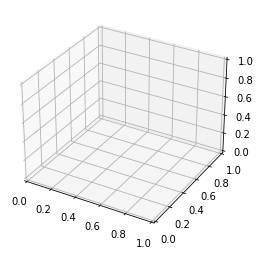

In [157]:
u, v, z = np.mgrid[0:1:4j, 0:1:4j, 0:1:4j]
# print(u)
# print(v)
plt.rcParams["figure.figsize"] = [7.00, 3.5]
plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(u, v, cmap=plt.cm.YlGnBu_r)
plt.show()

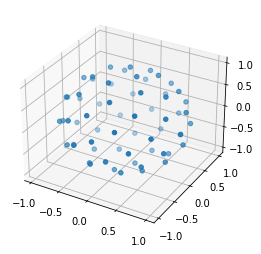

In [120]:
def fibonacci_sphere(num_points: int):
    ga = (3 - np.sqrt(5)) * np.pi # golden angle                                                                             

    # Create a list of golden angle increments along tha range of number of points                                           
    theta = ga * np.arange(num_points)

    # Z is a split into a range of -1 to 1 in order to create a unit circle                                                  
    z = np.linspace(1/num_points-1, 1-1/num_points, num_points)

    # a list of the radii at each height step of the unit circle                                                             
    radius = np.sqrt(1 - z * z)

    # Determine where xy fall on the sphere, given the azimuthal and polar angles                                            
    y = radius * np.sin(theta)
    x = radius * np.cos(theta)

    # Display points in a scatter plot                                                                                       
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z)
    plt.show()
    
fibonacci_sphere(64)

(16, 16)
[0.00000000e+00 2.07911691e-01 4.06736643e-01 5.87785252e-01
 7.43144825e-01 8.66025404e-01 9.51056516e-01 9.94521895e-01
 9.94521895e-01 9.51056516e-01 8.66025404e-01 7.43144825e-01
 5.87785252e-01 4.06736643e-01 2.07911691e-01 1.22464680e-16] [0.00000000e+00 8.45653032e-02 1.65434697e-01 2.39073800e-01
 3.02264232e-01 3.52244266e-01 3.86829535e-01 4.04508497e-01
 4.04508497e-01 3.86829535e-01 3.52244266e-01 3.02264232e-01
 2.39073800e-01 1.65434697e-01 8.45653032e-02 4.98108728e-17] [ 1.          0.9781476   0.91354546  0.80901699  0.66913061  0.5
  0.30901699  0.10452846 -0.10452846 -0.30901699 -0.5        -0.66913061
 -0.80901699 -0.91354546 -0.9781476  -1.        ]


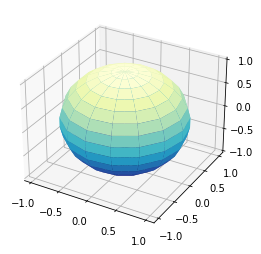

In [142]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["figure.figsize"] = [7.00, 3.5]
plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
r = 0.05
u, v = np.mgrid[0:2 * np.pi:16j, 0:np.pi:16j]
print(u.shape)
x = np.cos(u) * np.sin(v)
y = np.sin(u) * np.sin(v)
z = np.cos(v)
print(x[0], y[1], z[0])
ax.plot_surface(x, y, z, cmap=plt.cm.YlGnBu_r)
plt.show()

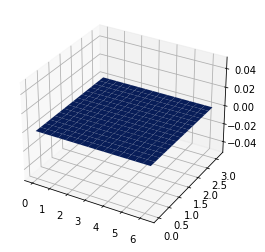

In [43]:
# plt.rcParams["figure.figsize"] = [7.00, 3.5]
# plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
# r = 0.05
# u, v = np.mgrid[0:2 * np.pi:30j, 0:np.pi:20j]
# x = np.cos(u) * np.sin(v)
# y = np.sin(u) * np.sin(v)
# z = np.cos(v)
u, v = np.mgrid[0:2 * np.pi:16j, 0:np.pi:16j]
# x = np.linspace(0, 1)
# y = np.linspace(0, 1)
z = u * 0
# print(len(x), len(y), len(z))
# ax.plot_surface(x, y, z, cmap=plt.cm.YlGnBu_r)
ax.plot_surface(u, v, z, cmap=plt.cm.YlGnBu_r)
plt.show()

(256, 3)
[[1.25663706 0.20943951 1.        ]
 [1.25663706 0.41887902 1.        ]
 [1.25663706 0.62831853 1.        ]
 [1.25663706 0.83775804 1.        ]
 [1.25663706 1.04719755 1.        ]
 [1.25663706 1.25663706 1.        ]
 [1.25663706 1.46607657 1.        ]
 [1.25663706 1.67551608 1.        ]
 [1.25663706 1.88495559 1.        ]
 [1.25663706 2.0943951  1.        ]
 [1.25663706 2.30383461 1.        ]]
(16, 16)
(16, 16)
0.18993678073735687 0.08456530317942909 0.9781476007338057


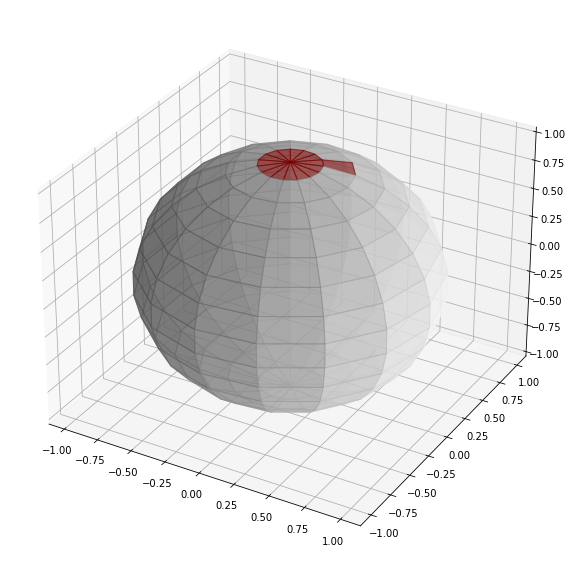

In [197]:
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

#theta inclination angle
#phi azimuthal angle
n_theta = 16 # number of values for theta
n_phi = 16  # number of values for phi
r = 1        #radius of sphere

theta, phi = np.mgrid[0.0:1*np.pi:n_theta*1j, 0.0:2.0*np.pi:n_phi*1j]

x = r*np.sin(theta)*np.cos(phi)
y = r*np.sin(theta)*np.sin(phi)
z = r*np.cos(theta)

# mimic the input array
# array columns phi, theta, value
# first n_theta entries: phi=0, second n_theta entries: phi=0.0315..
points = np.array(fibonacci_sphere(samples=32))
inp = []
for j in phi[0,:]:
    for i in theta[:,0]:
#         val = 0.7+np.cos(j)*np.sin(i+np.pi/4.)# put something useful here
        _x = r*np.sin(i)*np.cos(j)
        _y = r*np.sin(i)*np.sin(j)
        _z = r*np.cos(i)
#         diff = points - (-1, 0, 0)
#         # print(diff)
#         print(points[np.argmin(np.linalg.norm(diff, axis=1))])
        val = np.linalg.norm(np.array((_x, _y, _z)) - np.array((1, 0, 0))) > 0.01
        inp.append([j, i, val])
inp = np.array(inp)
print(inp.shape)
print(inp[49:60, :])

#reshape the input array to the shape of the x,y,z arrays. 
c = inp[:,2].reshape((n_phi,n_theta)).T
print(z.shape)
print(c.shape)

c = np.ones((n_phi, n_theta))
c[0,0:n_theta] = 0.25
c[1,1] = 0.25
print(x[1,1], y[1,1], z[1,1])

#Set colours and render
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
#use facecolors argument, provide array of same shape as z
# cm.<cmapname>() allows to get rgba color from array.
# array must be normalized between 0 and 1
# ax.plot_surface(
#     x,y,z,  rstride=1, cstride=1, facecolors=cm.hot(c/c.max()), alpha=0.6, linewidth=1) 
ax.plot_surface(
    x,y,z,  rstride=1, cstride=1, facecolors=cm.hot(c), alpha=0.6, linewidth=1) 
# ax.set_xlim([-2.2,2.2])
# ax.set_ylim([-2.2,2.2])
# ax.set_zlim([0,4.4])
# ax.set_aspect("equal")
#ax.plot_wireframe(x, y, z, color="k") #not needed?!
# plt.savefig(__file__+".png")
plt.show()

In [60]:
import random
def get_magic_state_result():
    bs = random.getrandbits(5)
    result = ''.join('{:05b}'.format(bs))
    return result
print(get_magic_state_result())

10101


In [348]:
class Game:    
    def __init__(self):
        print("init")
        self.backend = StatevectorSimulator()
        self.state = QuantumCircuit(1)
        self.gates = []
        self.points = []
        self.n_theta = 16 # number of values for theta
        self.n_phi = 16  # number of values for phi
        self.fib_sphere = np.array(Game._fibonacci_sphere(self.n_theta * self.n_phi))
        self.covered = np.zeros(len(self.fib_sphere))
#         np.ones((self.n_theta, self.n_phi))
        self.theta, self.phi = np.mgrid[0.0:1*np.pi:n_theta*1j, 0.0:2.0*np.pi:n_phi*1j]    

    @staticmethod
    def _fibonacci_sphere(samples=1000):
        # from https://stackoverflow.com/questions/9600801/evenly-distributing-n-points-on-a-sphere

        points = []
        phi = math.pi * (3. - math.sqrt(5.))  # golden angle in radians

        for i in range(samples):
            y = 1 - (i / float(samples - 1)) * 2  # y goes from 1 to -1
            radius = math.sqrt(1 - y * y)  # radius at y

            theta = phi * i  # golden angle increment

            x = math.cos(theta) * radius
            z = math.sin(theta) * radius

            points.append((x, y, z))
            
        return points

    @staticmethod
    def _statevector_to_cartesian(sv):
#         r = 1
#         theta = np.arccos(sv[0].real) * 2
#         phi = np.arcsin((sv[1] / np.sin(theta/2)).imag)
#         bloch = np.zeros(3)
#         bloch[0] = r*np.sin(theta)*np.cos(phi)
#         bloch[1] = r*np.sin(theta)*np.sin(phi)
#         bloch[2] = r*np.cos(theta)
#         return bloch
        # from https://en.wikipedia.org/wiki/Bloch_sphere#Plotting_pure_two-spinor_states_through_stereographic_projection
        u = sv[1] / sv[0]
        ux = u.real
        uy = u.imag
        x = 2 * ux / (1 + ux**2 + uy**2)
        y = 2 * uy / (1 + ux**2 + uy**2)
        z = (1 - ux**2 - uy**2) / (1 + ux**2 + uy**2)
        return np.array([x, y, z])
    
    def add_gate(self, gate):
        op = getattr(self.state, gate)
        op(0)
        results = self.backend.run(self.state).result()
        psi = results.get_statevector()
        point = Game._statevector_to_cartesian(psi)
        self.points.append(point)
        
        # update what areas are covered
        print(psi)
        print(point)
        diff = np.array(self.fib_sphere) - point
        index = np.argmin(np.linalg.norm(diff, axis=1))
        self.covered[index] = 1
        print(self.covered)
          
#         r = 1
#         for j in self.phi[0,:]:
#             for i in self.theta[:,0]:
#                 _x = r*np.sin(i)*np.cos(j)
#                 _y = r*np.sin(i)*np.sin(j)
#                 _z = r*np.cos(i)
#                 diff = points - (_x, _y, _z)
#                 points[np.argmin(np.linalg.norm(diff, axis=1))]
#         #         # print(diff)
#         #         print(points[np.argmin(np.linalg.norm(diff, axis=1))])
#                 val = np.linalg.norm(np.array((_x, _y, _z)) - np.array((1, 0, 0))) > 0.01
#                 inp.append([j, i, val])

    def draw(self):
        # from https://stackoverflow.com/questions/41105754/heat-map-half-sphere-plot
        r = 1        #radius of sphere

        theta, phi = np.mgrid[0.0:1*np.pi:n_theta*1j, 0.0:2.0*np.pi:n_phi*1j]

        x = r*np.sin(theta)*np.cos(phi)
        y = r*np.sin(theta)*np.sin(phi)
        z = r*np.cos(theta)

        # mimic the input array
        # array columns phi, theta, value
        # first n_theta entries: phi=0, second n_theta entries: phi=0.0315..
        points = np.array(fibonacci_sphere(samples=32))
        inp = []
        for j in phi[0,:]:
            for i in theta[:,0]:
                _x = r*np.sin(i)*np.cos(j)
                _y = r*np.sin(i)*np.sin(j)
                _z = r*np.cos(i)
                diff = np.array(self.fib_sphere) - (_x, _y, _z)
                index = np.argmin(np.linalg.norm(diff, axis=1))
                if (self.covered[index] > 0):
                    print(index)
#                 val = np.linalg.norm(np.array((_x, _y, _z)) - np.array((1, 0, 0))) > 0.01
                val = 1 - self.covered[index] * 0.75
                inp.append([j, i, val])
        inp = np.array(inp)
#         print(inp.shape)
#         print(inp[49:60, :])

        #reshape the input array to the shape of the x,y,z arrays. 
        c = inp[:,2].reshape((n_phi,n_theta)).T
#         print(z.shape)
#         print(c.shape)

#         c = np.ones((n_phi, n_theta))
#         c[0,0:n_theta] = 0.25
#         c[1,1] = 0.25
#         print(x[1,1], y[1,1], z[1,1])

        #Set colours and render
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        #use facecolors argument, provide array of same shape as z
        # cm.<cmapname>() allows to get rgba color from array.
        # array must be normalized between 0 and 1
        # ax.plot_surface(
        #     x,y,z,  rstride=1, cstride=1, facecolors=cm.hot(c/c.max()), alpha=0.6, linewidth=1) 
        ax.plot_surface(
            x,y,z,  rstride=1, cstride=1, facecolors=cm.hot(c), alpha=0.6, linewidth=1) 
        # ax.set_xlim([-2.2,2.2])
        # ax.set_ylim([-2.2,2.2])
        # ax.set_zlim([0,4.4])
        # ax.set_aspect("equal")
        #ax.plot_wireframe(x, y, z, color="k") #not needed?!
        # plt.savefig(__file__+".png")
        plt.show()

In [349]:
game = Game()

init


[0.70710678+0.j 0.70710678+0.j]
[1.00000000e+00 0.00000000e+00 2.22044605e-16]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


┌───┐
q_0: ┤ H ├
     └───┘

123
123


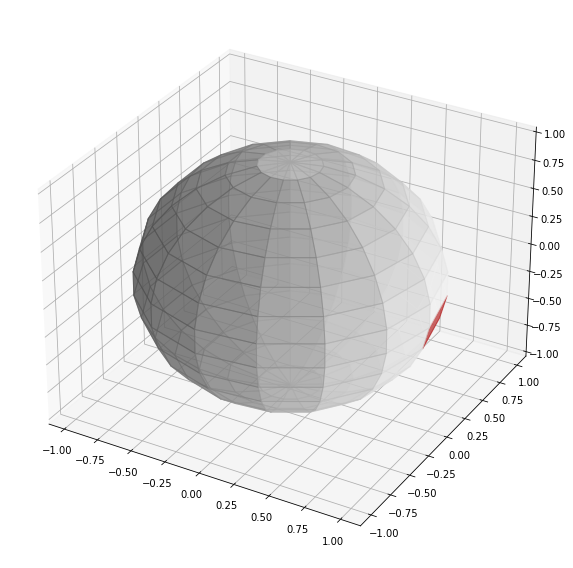

None

In [350]:
game.add_gate('h')
display(game.state.draw())
display(game.draw())
# print(game.points)